In [1]:
import wandb
import os
import pickle
import shutil
from pathlib import Path
from typing import List, Union


def get_runs(user="", project="", query={}, **kwargs):
    api = wandb.Api()
    runs = api.runs(path=f"{user}/{project}", filters=query)
    return runs
    #dataframes = [run.history(**kwargs) for run in runs]
    #return list(zip(runs, dataframes))

In [2]:
# Cifar10
queries = {}

## Xent undersampled
queries["xent-undersampled"] = ("hashimoto-group",
    {"$and": [{"state": "finished"},
              {"group": {"$in": ["2021-11-15_cifar_undersampled"]}},
             ]
})

## Poly loss
queries["poly"] = ("hashimoto-group",
    {"$and": [{"state": "finished"},
              {"group": {"$in": ["2021-11-13_tune_cifar_alpha_squared"]}},
              {"config.loss_fn/alpha": 2},
              {"config.datamodule/train_weight_exponent": 3},
             ]
})

## LDAM Loss
queries["ldam"] = ("hashimoto-group",
    {"$and": [{"state": "finished"},
              {"group": {"$in": ["2021-11-11_best_ldam"]}},
             ]
})

## CDT Loss
queries["cdt"] = ("hashimoto-group",
    {"$and": [{"state": "finished"},
              {"group": {"$in": ["2021-11-11_best_cdtloss"]}},
             ]
})

## LA Loss
queries["la"] = ("hashimoto-group",
    {"$and": [{"state": "finished"},
              {"group": {"$in": ["2021-11-11_best_laloss"]}},
             ]
})

## VS Loss (close to published hyperparameters)
queries["vs1"] = ("hashimoto-group",
    {"$and": [{"state": "finished"},
              {"group": {"$in": ["2021-11-10_vsloss"]}},
             ]
})

## VS Loss (better tuned)
queries["vs2"] = ("hashimoto-group",
    {"$and": [{"state": "finished"},
              {"group": {"$in": ["2021-11-11_best_vsloss"]}},
             ]
})

In [3]:
def parse_run(run):
    config = run.config
    df = run.history(keys=["test/test_reweighted_acc"])
    
    acc = df["test/test_reweighted_acc"].dropna().iloc[0] # there should only be one logged
    assert acc > 0.
    stats = {
        "name": run.name,
        "loss": config["loss_fn/_target_"],
        "dataset": config["datamodule/group_datamodule_cls_name"],
        "seed": config["seed"],
        "acc": acc,
    }
    return stats

In [4]:
stats_list = []
for query_name, user__query in queries.items():
    user, query = user__query
    project = "importance-reweighing"
    runs = get_runs(user=user, project=project, query=query)
    stats_of_runs = [parse_run(run) for run in runs]
    
    for stats in stats_of_runs:
        stats["query"] = query_name
    
    stats_list += stats_of_runs

In [5]:
import pandas as pd

df = pd.DataFrame(stats_list)

In [6]:
df.shape

(70, 6)

In [7]:
df.groupby("query").count()

,name,loss,dataset,seed,acc
query,,,,,
cdt,10,10,10,10,10
la,10,10,10,10,10
ldam,10,10,10,10,10
poly,10,10,10,10,10
vs1,10,10,10,10,10
vs2,10,10,10,10,10
xent-undersampled,10,10,10,10,10


In [8]:
df

,name,loss,dataset,seed,acc,query
0,laced-cloud-574,torch.nn.CrossEntropyLoss,ImbalancedCIFAR10DataModule,9,0.6000,xent-undersampled
1,dashing-glade-573,torch.nn.CrossEntropyLoss,ImbalancedCIFAR10DataModule,8,0.5880,xent-undersampled
2,divine-wildflower-572,torch.nn.CrossEntropyLoss,ImbalancedCIFAR10DataModule,7,0.5905,xent-undersampled
3,hardy-totem-569,torch.nn.CrossEntropyLoss,ImbalancedCIFAR10DataModule,6,0.5565,xent-undersampled
4,quiet-flower-571,torch.nn.CrossEntropyLoss,ImbalancedCIFAR10DataModule,5,0.5915,xent-undersampled
...,...,...,...,...,...,...
65,classic-galaxy-1934,src.loss_fns.VSLoss,ImbalancedCIFAR10DataModule,0,0.7045,vs2
66,robust-disco-1929,src.loss_fns.VSLoss,ImbalancedCIFAR10DataModule,7,0.6865,vs2
67,lucky-wave-1935,src.loss_fns.VSLoss,ImbalancedCIFAR10DataModule,1,0.6870,vs2
68,fast-smoke-1930,src.loss_fns.VSLoss,ImbalancedCIFAR10DataModule,8,0.7085,vs2


In [9]:
old_names = ['xent-undersampled', 'poly', 'ldam', 'cdt', 'la', 'vs1', 'vs2']
new_names = ['CE+US', 'Poly+IW', "LDAM", "CDT", "LA", "VS (published)", "VS (tuned)"]
for old, new in zip(old_names, new_names):
    df["query"] = df["query"].replace(old, new)

In [10]:
df.to_csv("sota-cifar-results.csv", index=False)

# Begin plots

In [11]:
import pandas as pd
df = pd.read_csv("sota-cifar-results.csv")

In [12]:
from collections import defaultdict
p_values = {query: defaultdict(float) for query in df["query"].unique()}

In [14]:
from hypothetical.hypothesis import tTest


df_ = df.copy()
for query in df_["query"].unique():
    other_accs = df_.loc[df_["query"] == query, ["seed", "acc"]]
    poly_accs = df_.loc[df_["loss"].str.contains("Poly"), ["seed", "acc"]]
    
    other_accs = other_accs.set_index("seed")
    poly_accs = poly_accs.set_index("seed")
    
    acc_pairs = pd.concat([other_accs.rename(columns={"acc": "other_acc"}),
                           poly_accs.rename(columns={"acc": "poly_acc"})],
                          axis=1
    )
    
    ttest = tTest(y1=acc_pairs["poly_acc"],
              y2=acc_pairs["other_acc"],
              var_equal=False,
              paired=True,
              alternative="greater",
              alpha=0.05
    )
    p_value = ttest.test_summary['p-value']
    print(f"poly is better than {query} with p value: {p_value:.5f}")
    p_values[query] = p_value

poly is better than CE+US with p value: 0.00000
poly is better than Poly+IW with p value: nan
poly is better than LDAM with p value: 0.00000
poly is better than CDT with p value: 0.00000
poly is better than LA with p value: 0.28039
poly is better than VS (published) with p value: 0.00000
poly is better than VS (tuned) with p value: 0.99977


In [15]:
def get_corners(rectangle):
    b = rectangle
    w,h = b.get_width(), b.get_height()
    # lower left vertex
    x0, y0 = b.xy
    # lower right vertex
    x1, y1 = x0 + w, y0
    # top left vertex
    x2, y2 = x0, y0 + h
    # top right vertex
    x3, y3 = x0 + w, y0 + h
    return (x0,y0), (x1,y1), (x2,y2), (x3,y3)

In [16]:
def outline_bracket(left_bar, right_bar, spacing, height):
    l0, l1, l2, l3 = get_corners(left_bar)
    r0, r1, r2, r3 = get_corners(right_bar)
    
    # lower left
    b0 = ((l0[0] + l1[0]) / 2, max(l2[1], r2[1]) + spacing)
    # upper left
    b1 = (b0[0], max(l2[1] + spacing, r2[1] + spacing) + height)
    # upper right
    b2 = ((r0[0] + r1[0]) / 2, b1[1])
    # lower right
    b3 = (b2[0], b0[1])
    return b0, b1, b2, b3

## Interpolation results

In [17]:
df_interp = df.copy()

In [18]:
df_interp

,name,loss,dataset,seed,acc,query
0,laced-cloud-574,torch.nn.CrossEntropyLoss,ImbalancedCIFAR10DataModule,9,0.6000,CE+US
1,dashing-glade-573,torch.nn.CrossEntropyLoss,ImbalancedCIFAR10DataModule,8,0.5880,CE+US
2,divine-wildflower-572,torch.nn.CrossEntropyLoss,ImbalancedCIFAR10DataModule,7,0.5905,CE+US
3,hardy-totem-569,torch.nn.CrossEntropyLoss,ImbalancedCIFAR10DataModule,6,0.5565,CE+US
4,quiet-flower-571,torch.nn.CrossEntropyLoss,ImbalancedCIFAR10DataModule,5,0.5915,CE+US
...,...,...,...,...,...,...
65,classic-galaxy-1934,src.loss_fns.VSLoss,ImbalancedCIFAR10DataModule,0,0.7045,VS (tuned)
66,robust-disco-1929,src.loss_fns.VSLoss,ImbalancedCIFAR10DataModule,7,0.6865,VS (tuned)
67,lucky-wave-1935,src.loss_fns.VSLoss,ImbalancedCIFAR10DataModule,1,0.6870,VS (tuned)
68,fast-smoke-1930,src.loss_fns.VSLoss,ImbalancedCIFAR10DataModule,8,0.7085,VS (tuned)


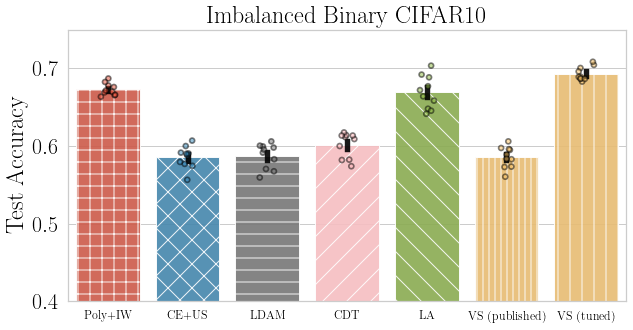

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style

plt.rc('text', usetex=True)
plt.rc('font', family='times')
#palette = ['#E24A33', '#348ABD', '#988ED5', '#777777', '#FBC15E', '#8EBA42', '#FFB5B8']
#palette = ['#E24A33', '#348ABD', '#777777', '#FFB5B8', '#8EBA42', '#16B69B', '#FBC15E']
palette = ['#E24A33', '#348ABD', '#777777', '#FFB5B8', '#8EBA42', '#FBC15E', '#FBC15E']
#palette = ['#E24A33', '#348ABD', '#777777', '#FBC15E', '#8EBA42', '#FFB5B8']
sns.set_palette(palette)

fig, ax = plt.subplots(figsize=(10, 5))
bar = sns.barplot(data=df_interp, x="query", y="acc", ax=ax, alpha=0.9, saturation=0.75, ci=68, errcolor=(0, 0, 0, 0.9),
                  order=['Poly+IW', 'CE+US', "LDAM", "CDT", "LA", "VS (published)", "VS (tuned)"])
sns.stripplot(data=df_interp, x="query", y="acc", ax=ax, alpha=0.5, dodge=True, edgecolor="black", linewidth=1.7,
              order=['Poly+IW', 'CE+US', "LDAM", "CDT", "LA", "VS (published)", "VS (tuned)"])
ax.set(ylim=[0.4, 0.75])
ax.set(title=r"Imbalanced Binary CIFAR10")
ax.set(ylabel=r"Test Accuracy")
ax.set(xlabel=None)
ax.tick_params(axis='x', labelsize=12)
ax.set(xlabel=None)

#bar.patches[0].set_hatch("+")
#bar.patches[0].set_edgecolor((1,1,1,1))
hatches = ["+","x","-", "/", "\\", "||", "|"]
for i, b in enumerate(bar.patches):
    b.set_hatch(hatches[i])
    b.set_edgecolor((1, 1, 1, 1.))

# queries = [label.get_text() for label in ax.get_xticklabels()]
# queries.remove("poly")

# for i in range(len(queries)):
#     query = queries[i]
#     p_value = p_values[query]
#     if p_value < 0.05:
#         star = r"$**$" if p_value < 0.005 else r"$*$"

#         left_bar = bar.patches[i]
#         right_bar = bar.patches[i + len(queries)]
#         bracket = outline_bracket(left_bar, right_bar, spacing=0.02, height=0.005)
#         b_xs, b_ys = list(zip(*bracket))
#         ax.plot(b_xs, b_ys, c="k")
#         ax.text((b_xs[1] + b_xs[2]) / 2, b_ys[1] + 0.005, star, ha="center", va="bottom", color="k", fontsize=30)
        
# if cifar_p_value < 0.05:
#     star = r"$**$" if cifar_p_value < 0.005 else r"$*$"

#     left_bar = bar.patches[3]
#     right_bar = bar.patches[2]
#     bracket = outline_bracket(left_bar, right_bar, spacing=0.035, height=0.005)
#     b_xs, b_ys = list(zip(*bracket))
#     ax.plot(b_xs, b_ys, c="k")
#     ax.text((b_xs[1] + b_xs[2]) / 2, b_ys[1] + 0.005, star, ha="center", va="bottom", color="k", fontsize=30)    

# ax.set(xticklabels=["No IW", "IW ($\overline w$)", r"IW ($\overline w^{3/2})$"])  # Put at the end because p_values dict is named using old keys
# ax.set_axisbelow(True)

In [44]:
fig.savefig("sota-cifar.pdf", bbox_inches="tight")